# Airbyte SQL Index Guide

We will show how to generate SQL queries on a Snowflake db generated by Airbyte.

In [ ]:
# Uncomment to enable debugging.

# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### Airbyte ingestion

Here we show how to ingest data from Zendesk into a Snowflake db using Airbyte.

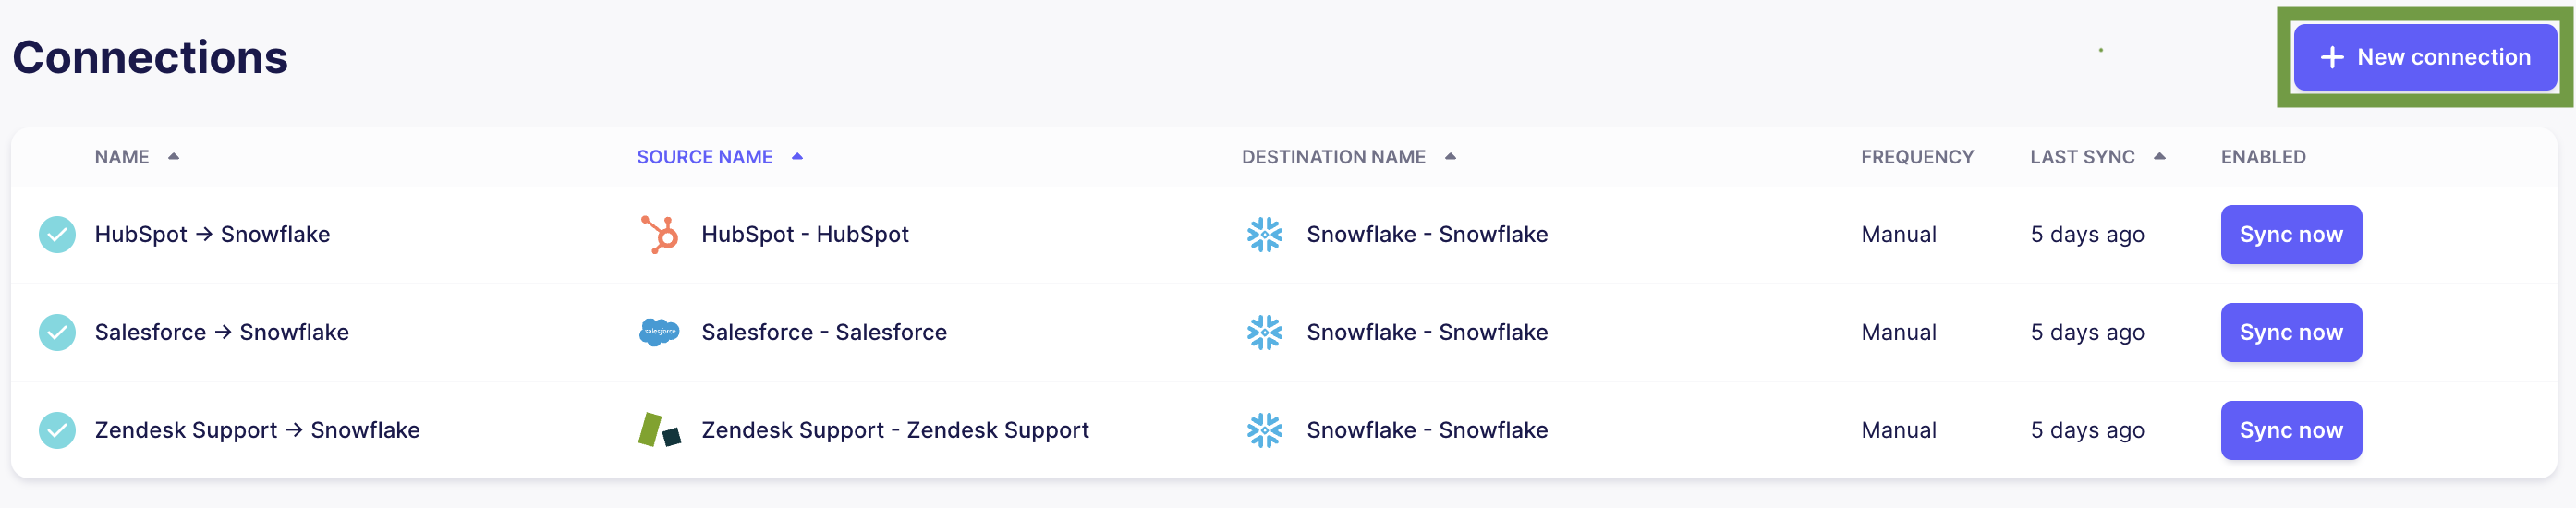

Let's create a new connection. Here we will be dumping our Zendesk tickets into a Snowflake db.

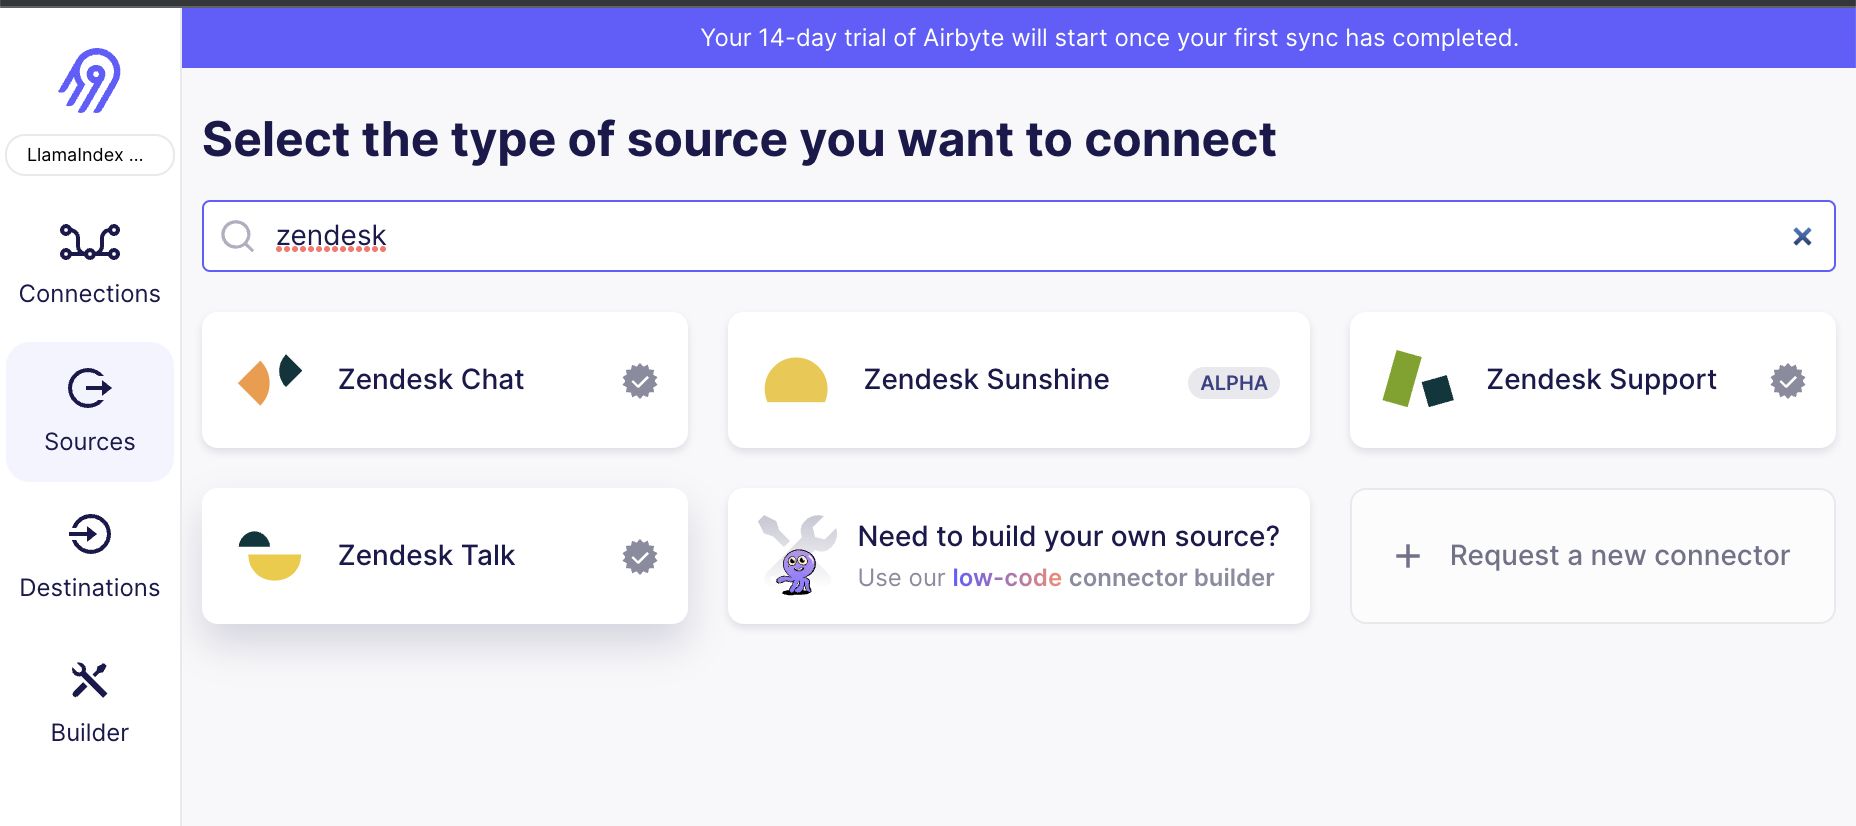

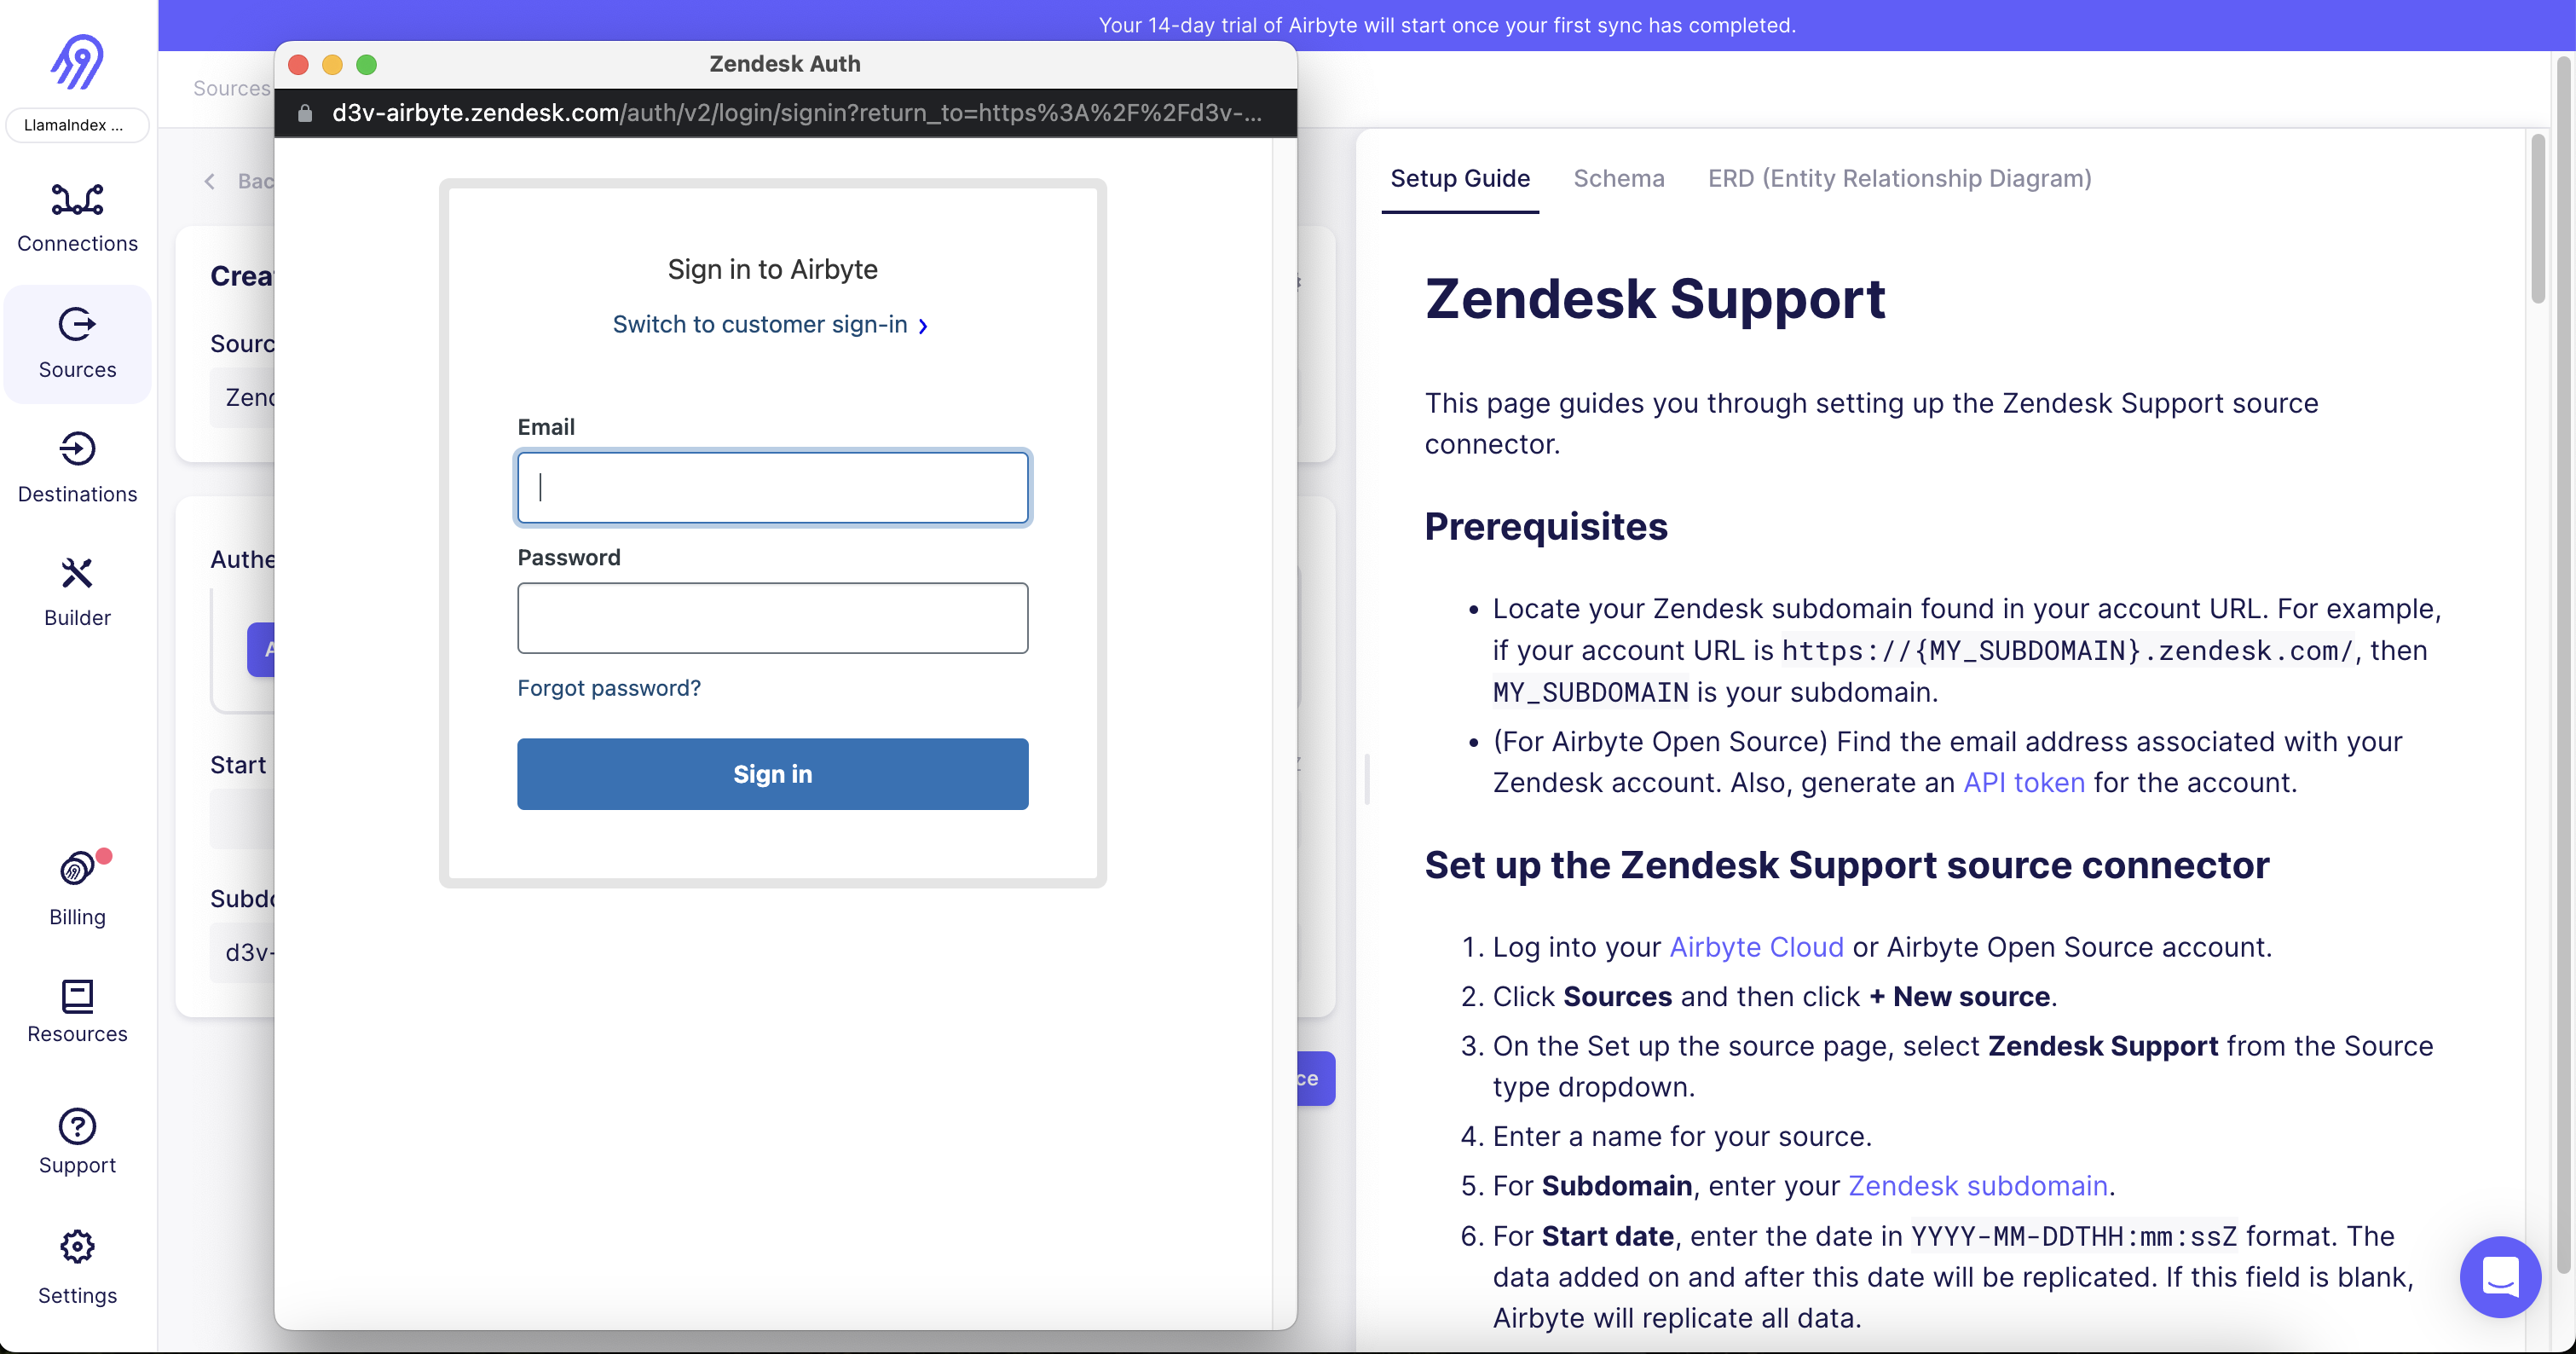

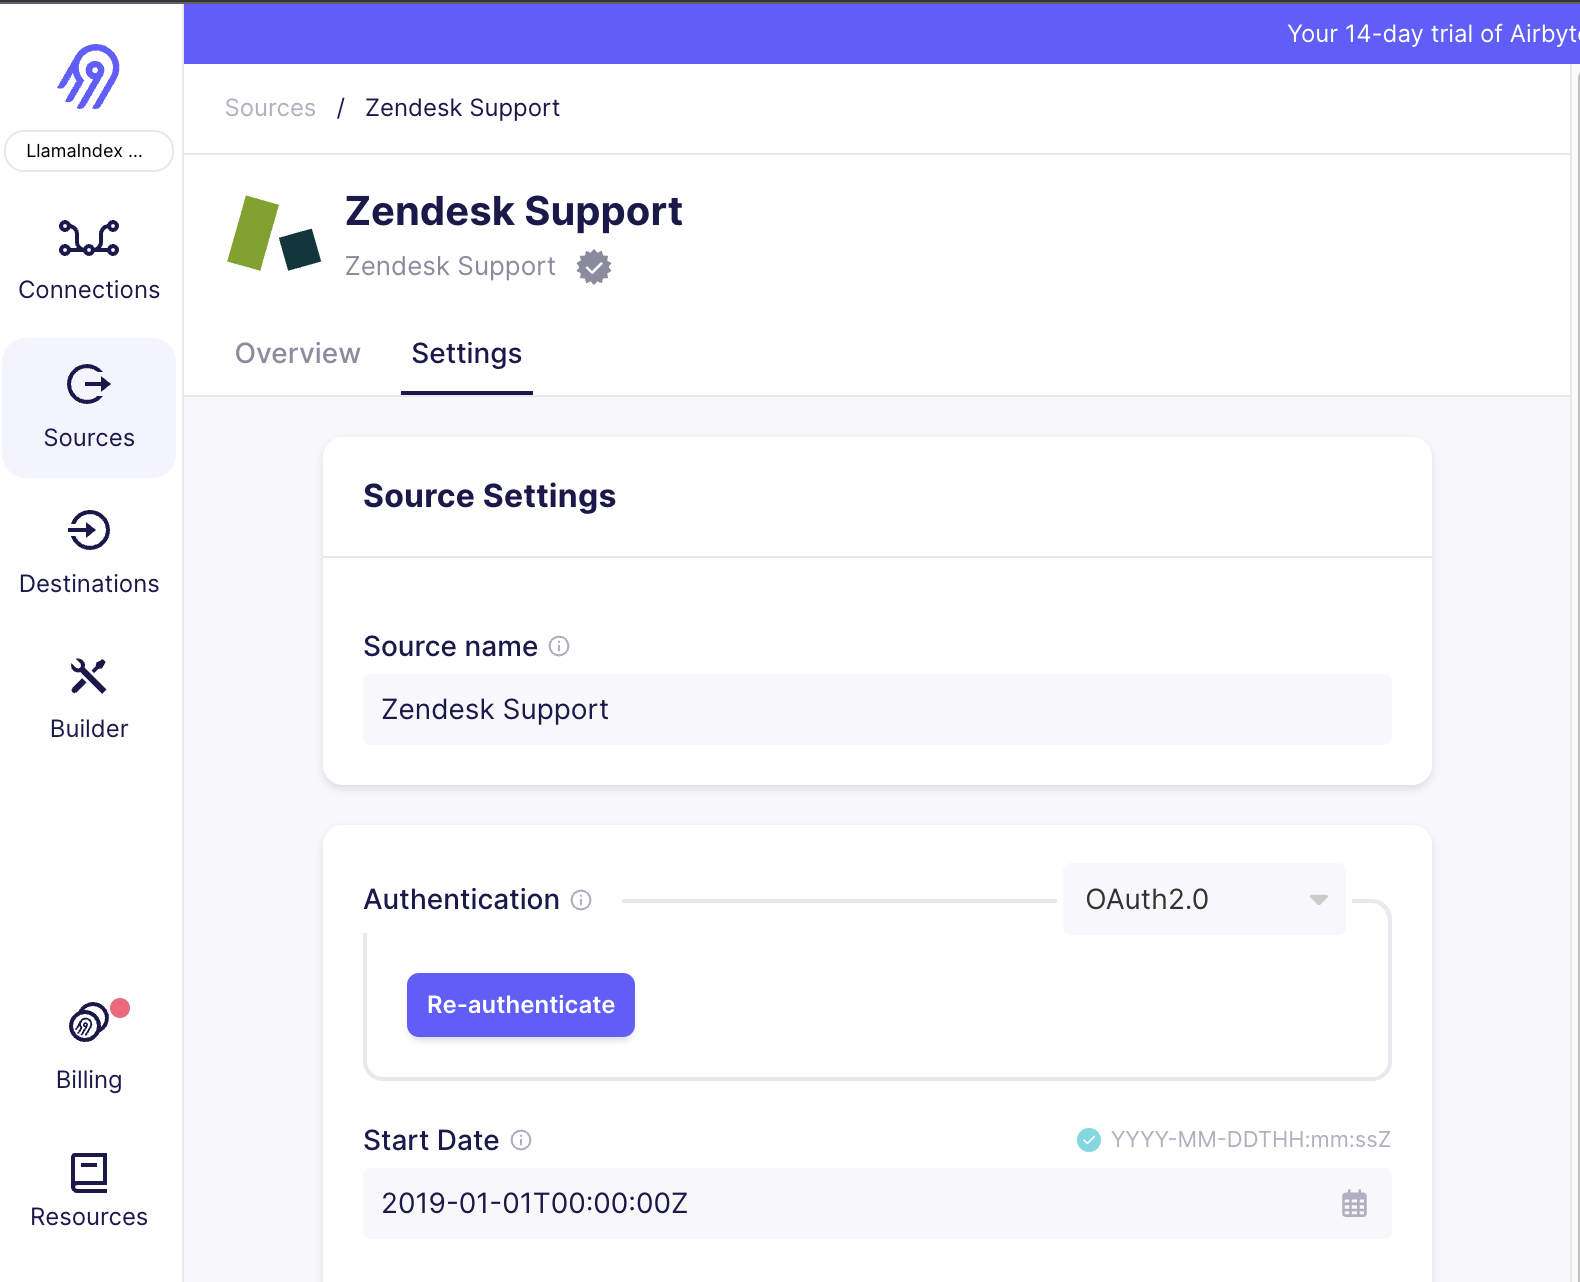

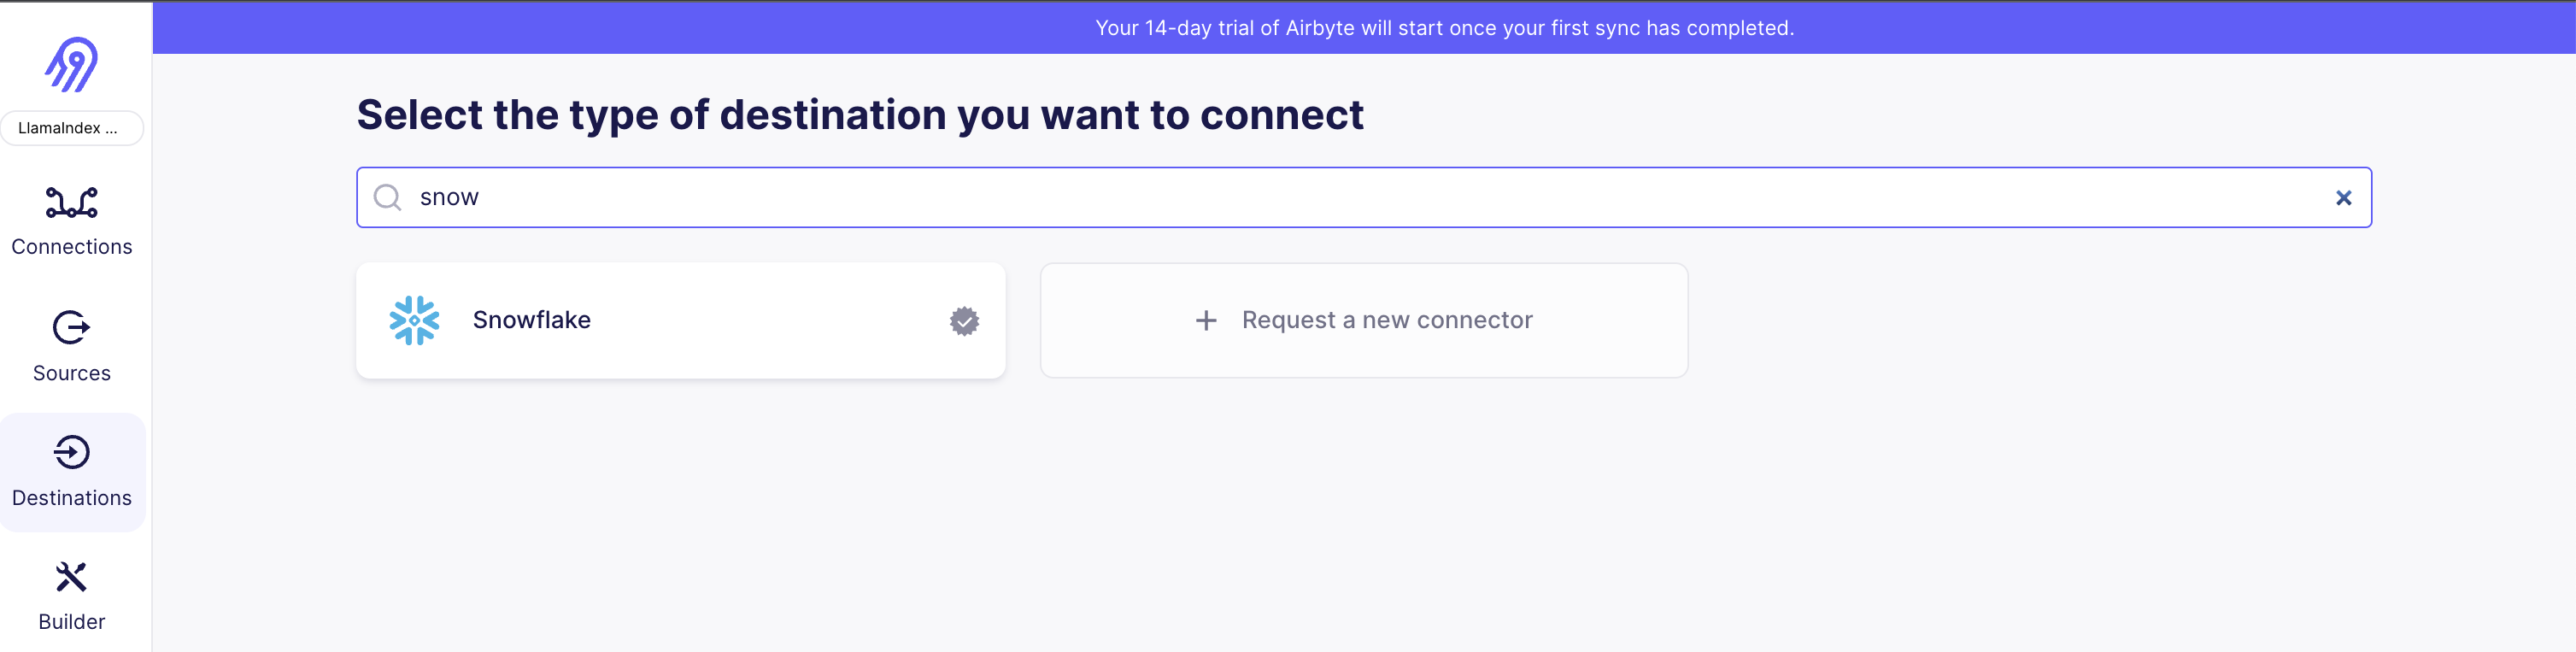

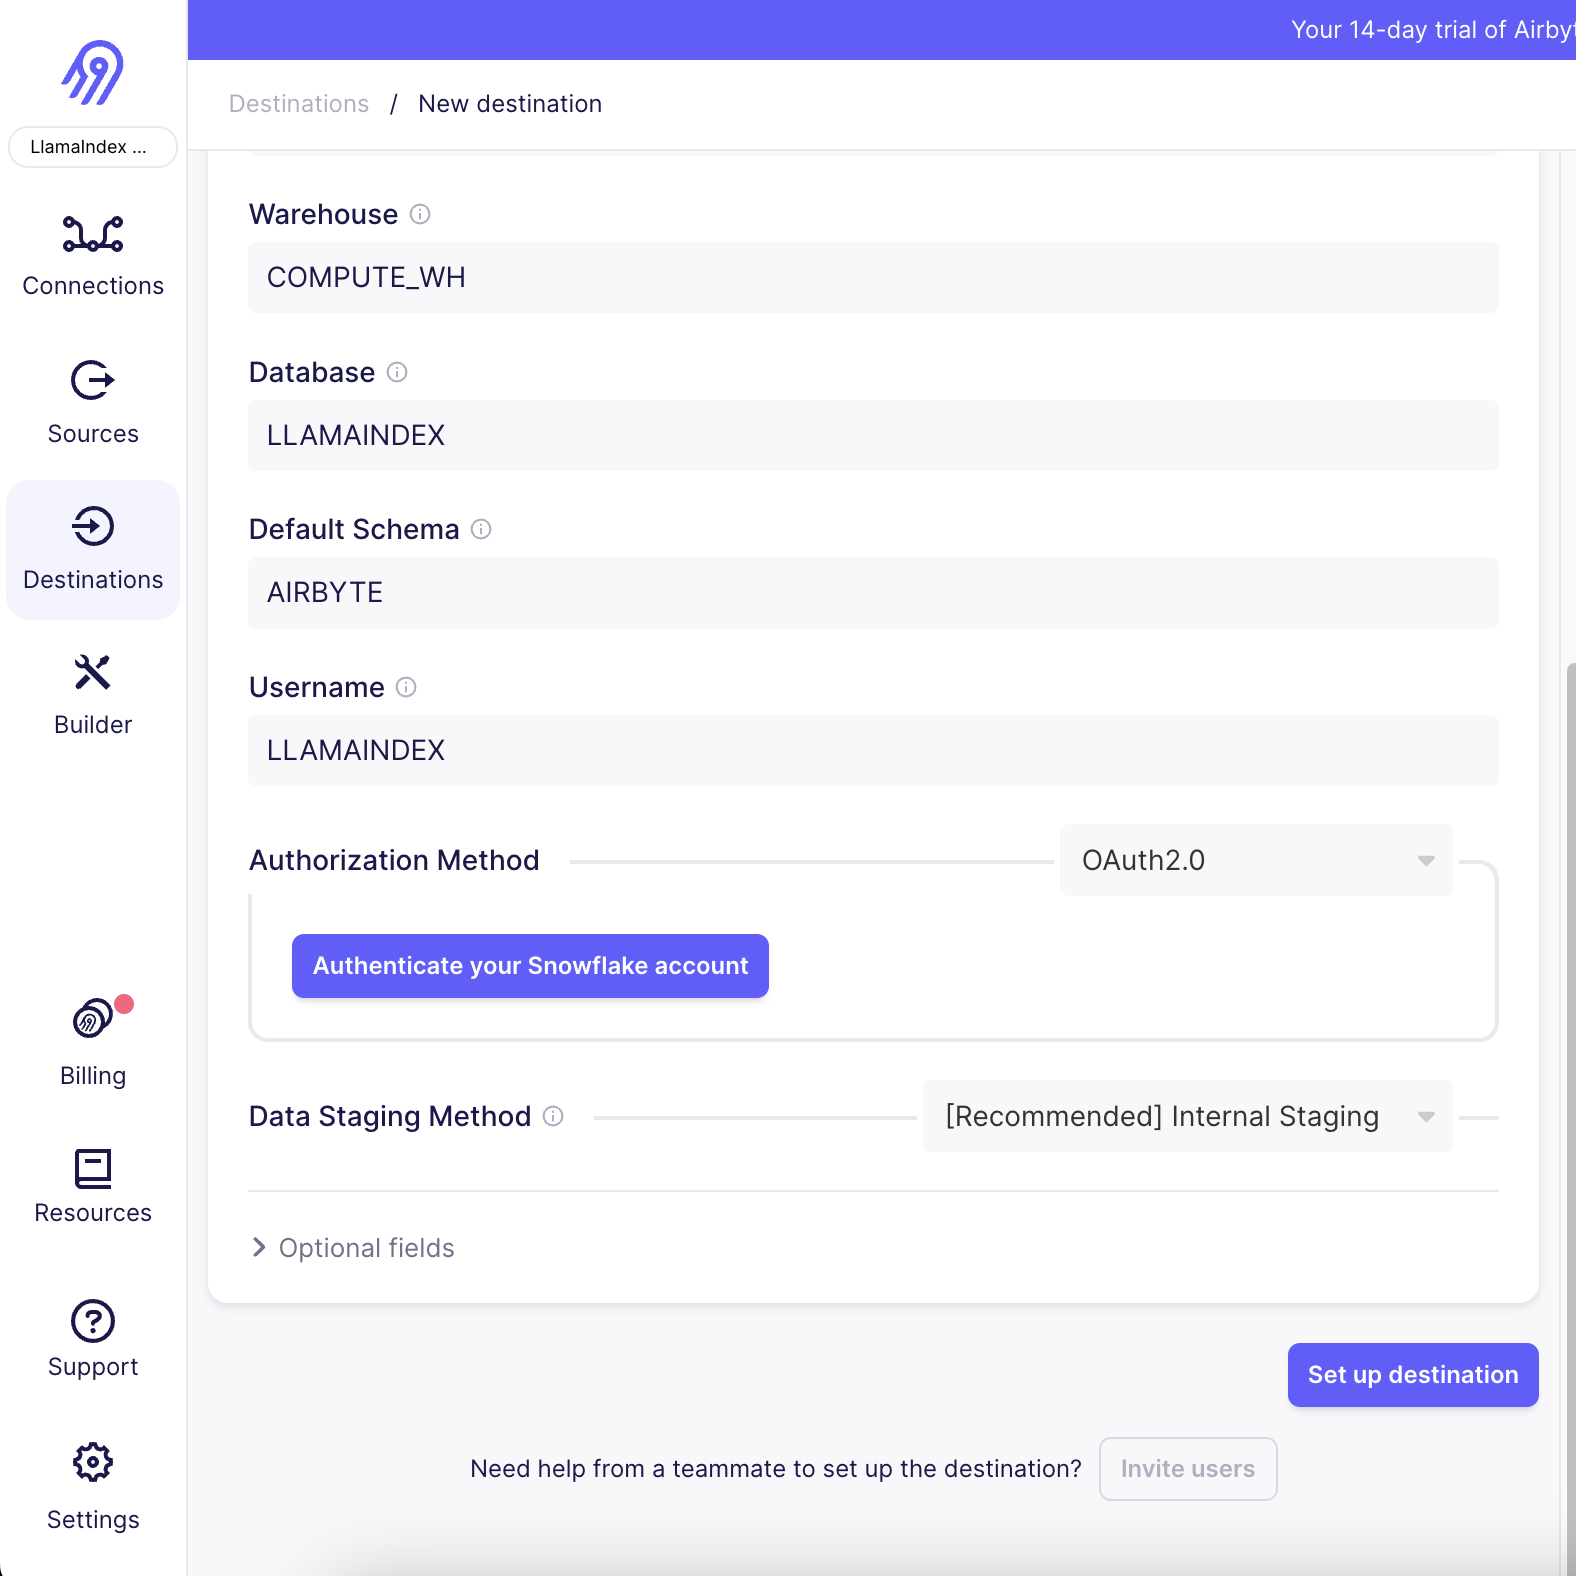

Choose the fields you want to sync.
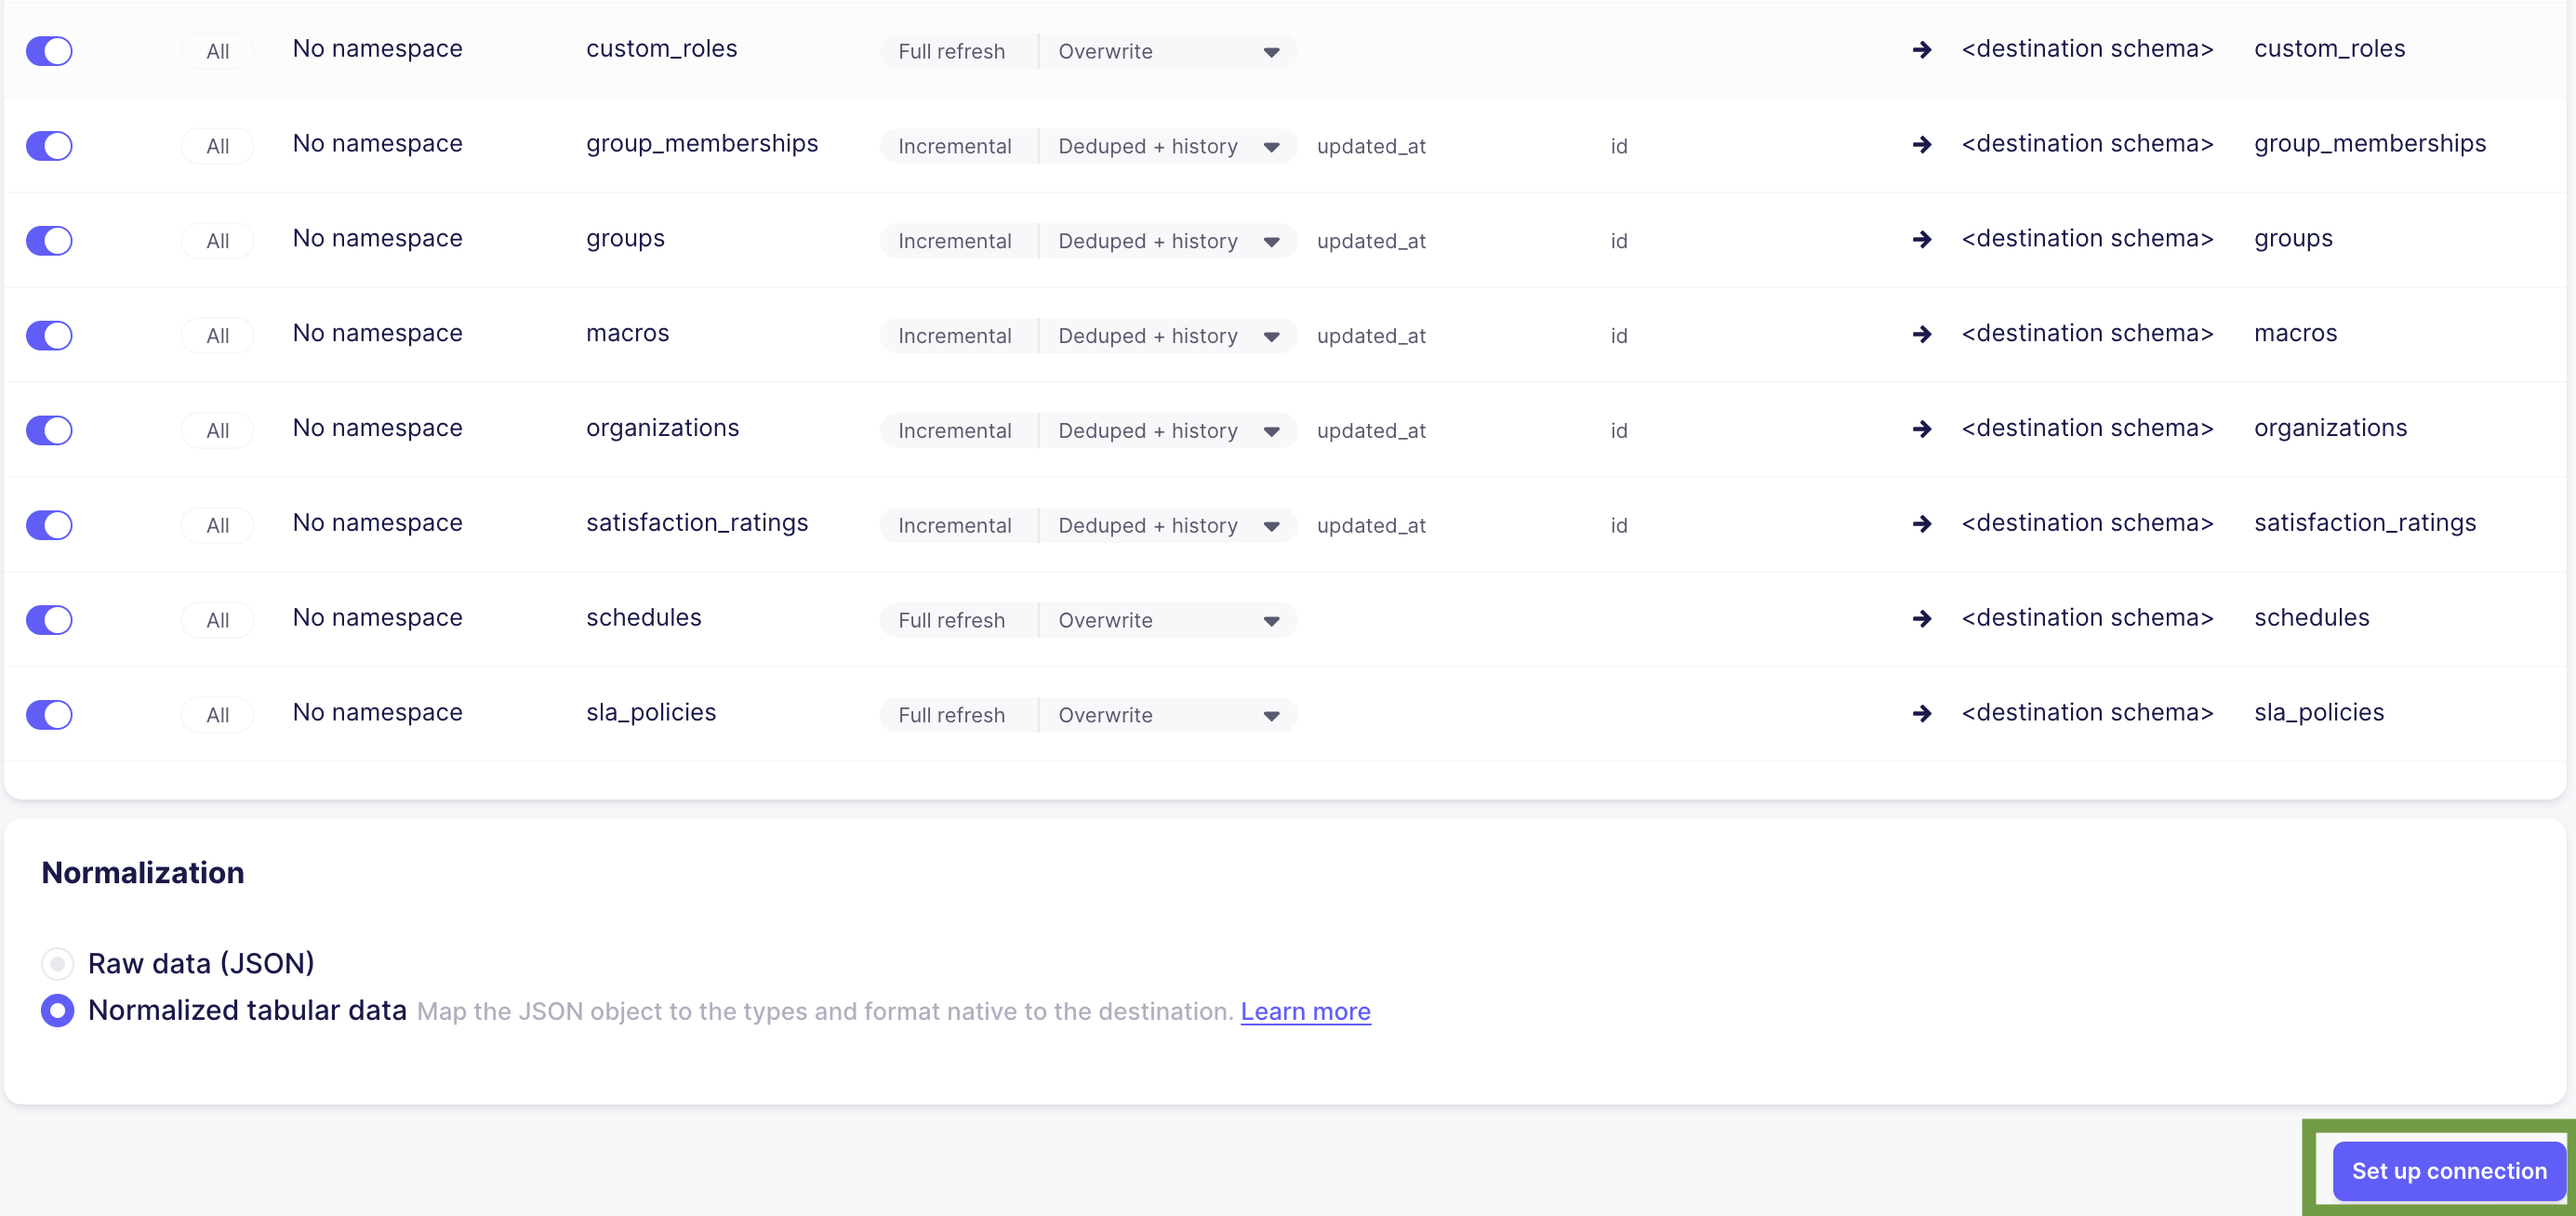

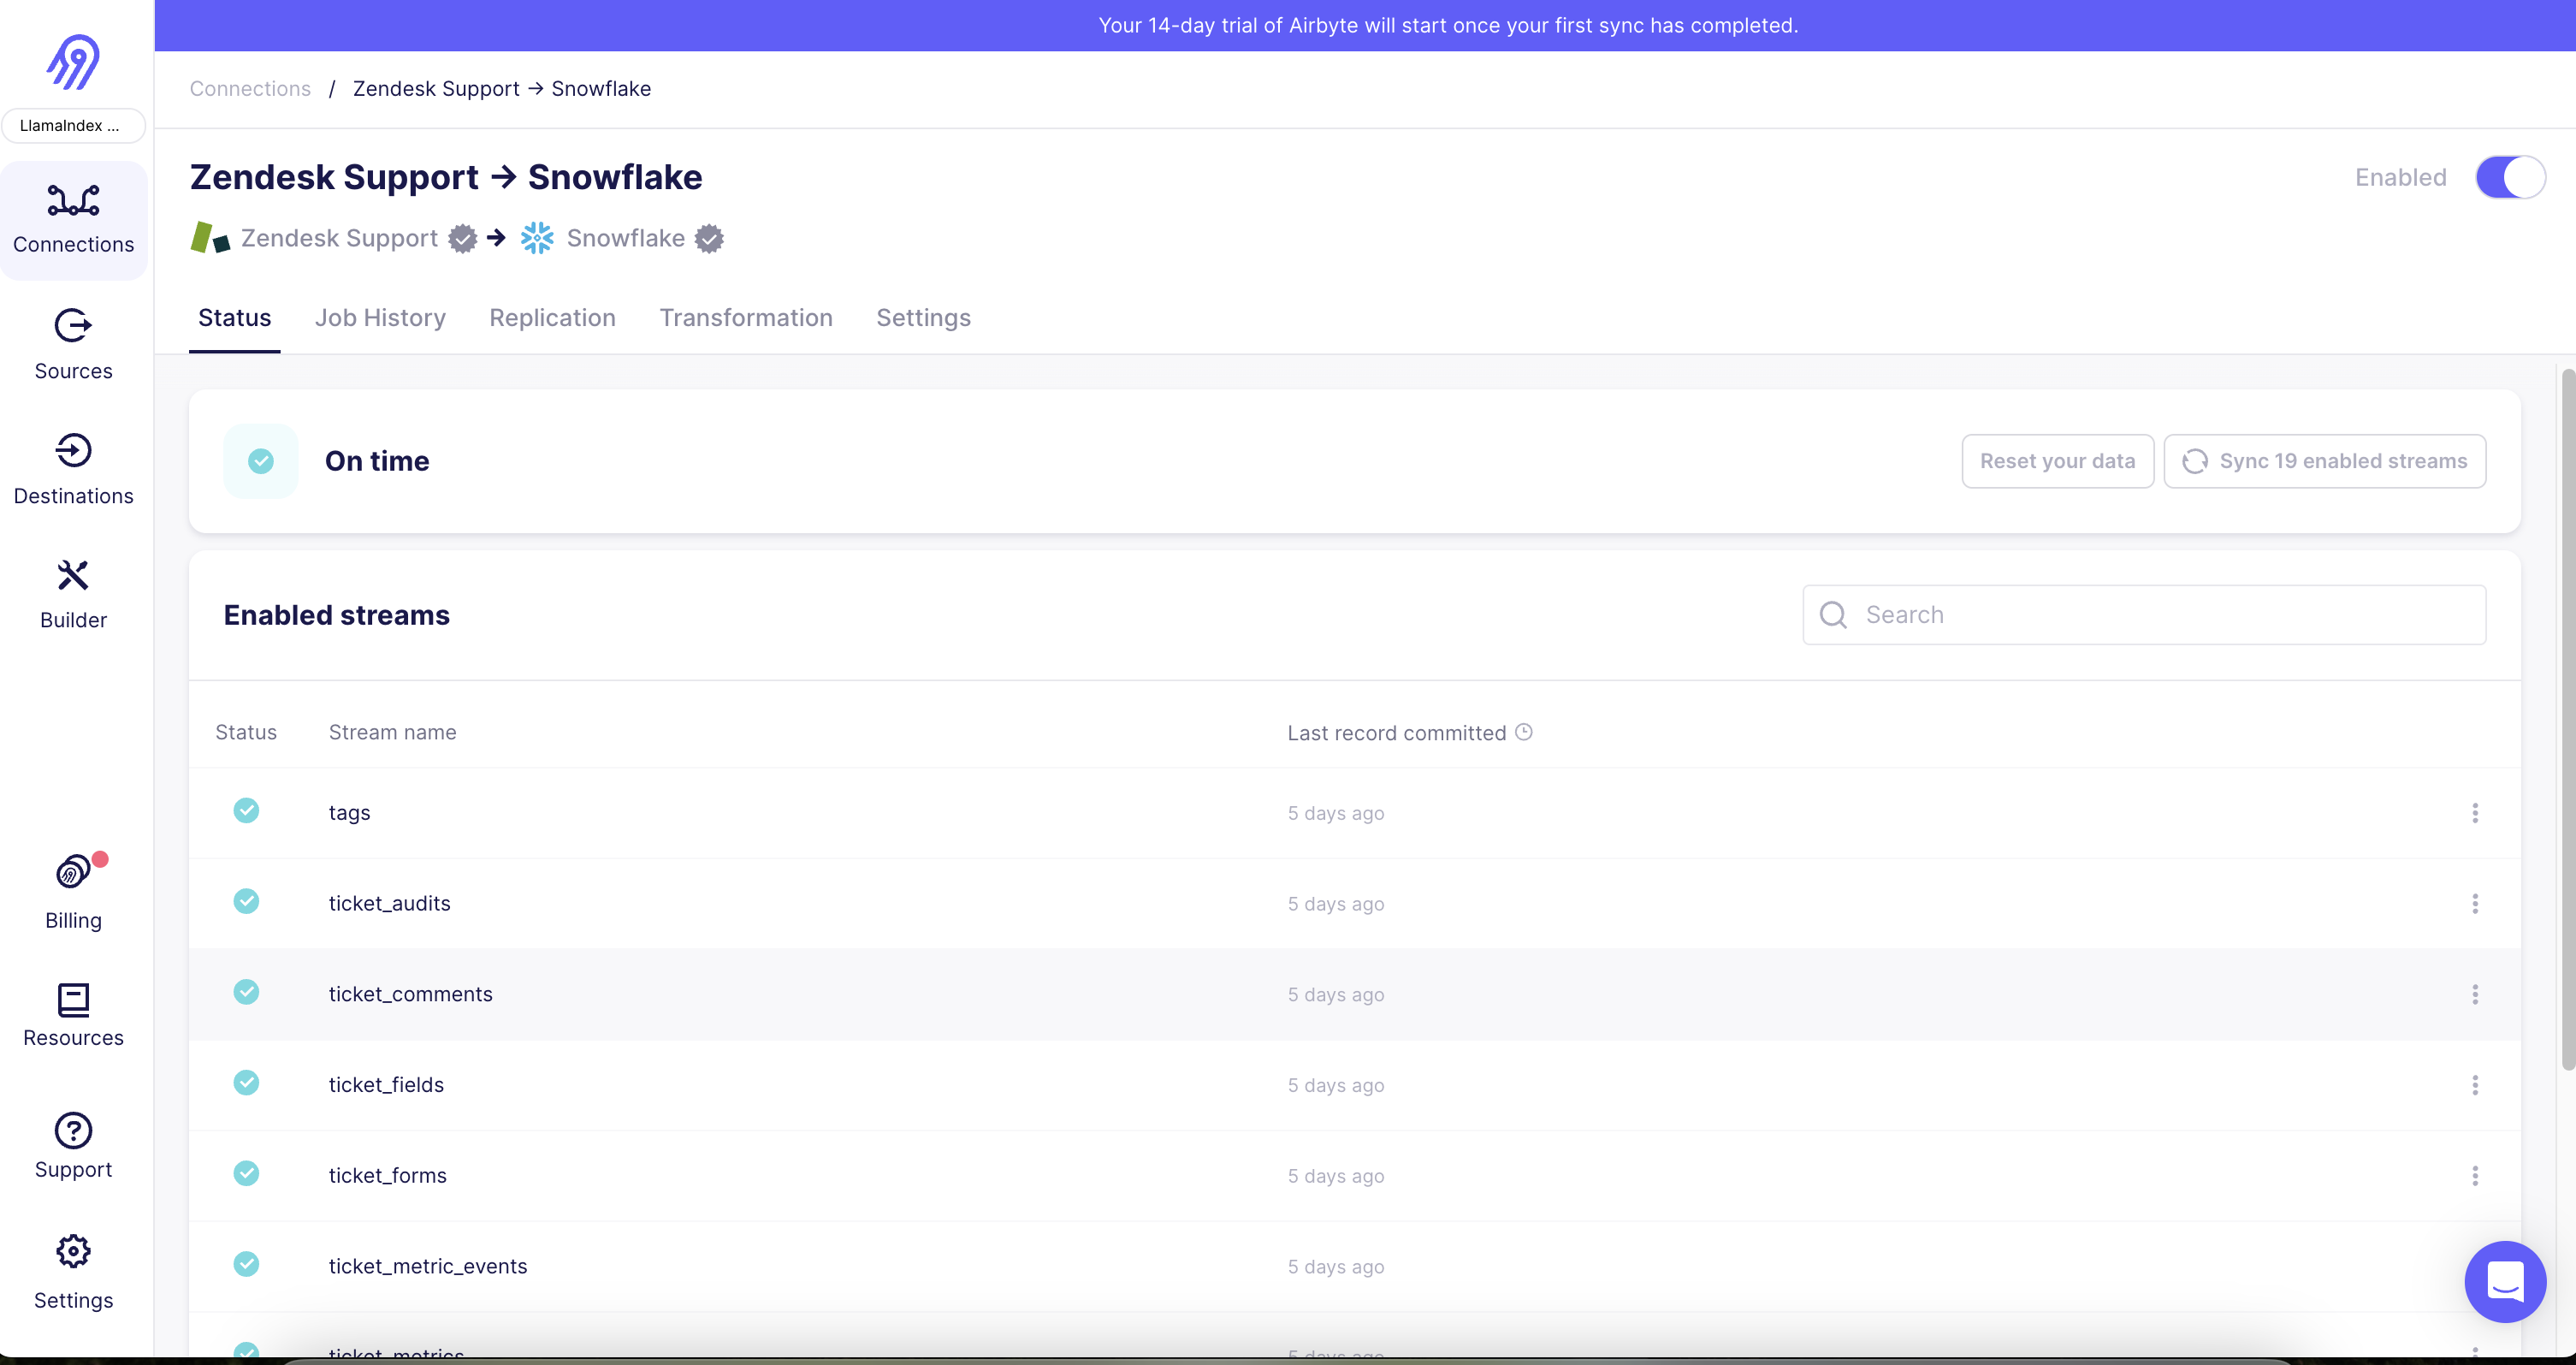

Sync your data.

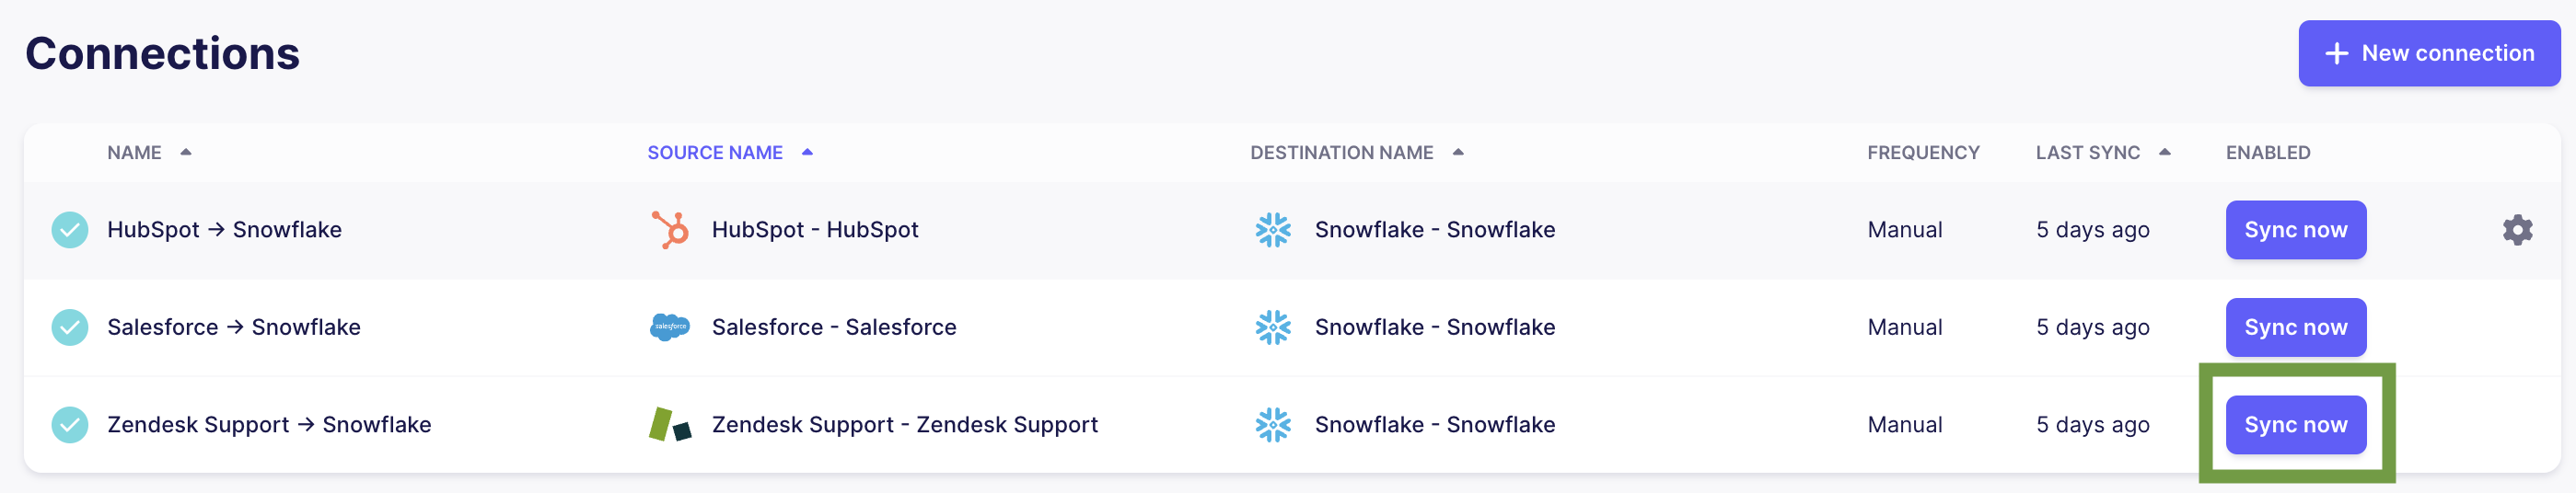

### Snowflake-SQLAlchemy version fix

Hack to make snowflake-sqlalchemy work despite incompatible sqlalchemy versions

Taken from https://github.com/snowflakedb/snowflake-sqlalchemy/issues/380#issuecomment-1470762025

In [ ]:
# Hack to make snowflake-sqlalchemy work until they patch it

def snowflake_sqlalchemy_20_monkey_patches():
    import sqlalchemy.util.compat

    # make strings always return unicode strings
    sqlalchemy.util.compat.string_types = (str,)
    sqlalchemy.types.String.RETURNS_UNICODE = True

    import snowflake.sqlalchemy.snowdialect

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.returns_unicode_strings = True

    # make has_table() support the `info_cache` kwarg
    import snowflake.sqlalchemy.snowdialect

    def has_table(self, connection, table_name, schema=None, info_cache=None):
        """
        Checks if the table exists
        """
        return self._has_object(connection, "TABLE", table_name, schema)

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.has_table = has_table

# usage: call this function before creating an engine:
try:
    snowflake_sqlalchemy_20_monkey_patches()
except Exception as e:
    raise ValueError("Please run `pip install snowflake-sqlalchemy`")

### Define database

We pass the Snowflake uri to the SQL db constructor

In [ ]:
snowflake_uri = 'snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>'


First we try connecting with sqlalchemy to check the db works.

In [ ]:
from sqlalchemy import select, create_engine, MetaData, Table

# view current table
engine = create_engine(snowflake_uri)
metadata = MetaData(bind=None)
table = Table(
    'ZENDESK_TICKETS', 
    metadata, 
    autoload=True, 
    autoload_with=engine
)
stmt = select(table.columns)


with engine.connect() as connection:
    results = connection.execute(stmt).fetchone()
    print(results)
    print(results.keys())


### Build Index

We then build the SQL Index (`SQLStructStoreIndex`).

In [ ]:
from llama_index import SQLStructStoreIndex, SQLDatabase, VectorStoreIndex
from llama_index.indices.struct_store import SQLContextContainerBuilder

sql_database = SQLDatabase(engine)
context_builder = SQLContextContainerBuilder(sql_database)
table_schema_index = context_builder.derive_index_from_context(
    VectorStoreIndex,
)
query_str = "When was the last ticket created?"
context_builder.query_index_for_context(table_schema_index, query_str, store_context_str=True)
context_container = context_builder.build_context_container()
index = SQLStructStoreIndex(
    sql_database=sql_database,
    sql_context_container=context_container,
)

Note that we add the context_container to restrict the prompt to only querying over the most relevant tables.
Otherwise we will get size overflow on our query.

### Query Index

We first show how we can execute a raw SQL query, which directly executes over the table.

In [ ]:
query_engine = index.as_query_engine(
    query_mode="sql"
)
response = query_engine.query("SELECT created_at FROM ZENDESK_TICKETS limit 5")

In [ ]:
from IPython.display import Markdown, display
display(Markdown(f"<b>{response}</b>"))

We then show a natural language query, which is translated to a SQL query under the hood with our text-to-SQL prompt.

In [ ]:

query_engine = index.as_query_engine()
display(Markdown(f"<b>{context_container.context_str}</b>"))
response = query_engine.query(query_str)

In [ ]:
display(Markdown(f"<b>{response}</b>"))

In [ ]:
# you can also fetch the raw result from SQLAlchemy! 
response.extra_info["result"]